In [34]:
!pip install torch-geometric

StatementMeta(team14elliptic, 23, 2, Finished, Available, Finished)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 31.4 MB/s eta 0:00:0000:01


In [46]:
# 1. Setup and Configuration
# --------------------------
# Configure storage account access
storage_account_name = "team14storage"
storage_account_key = "BqTUGm0vEddQ0O5wOaAzGNjFqZVnK4ZnhfvBYjBhfLbcBPoeO43ABkRBPhdgzwuyzoYDInfw0wjs+ASt89HrGw=="

spark.conf.set(
    f"fs.azure.account.key.{storage_account_name}.dfs.core.windows.net",
    storage_account_key
)

StatementMeta(team14elliptic, 23, 14, Finished, Available, Finished)

In [47]:
# 2. Data Loading
# ---------------
# Read each CSV into its own DataFrame
elliptic_txs_classes_df = (
    spark.read
        .option("header", "true")
        .option("inferSchema", "true")
        .csv(
            f"wasbs://team14-blobcontainer@{storage_account_name}"
            + ".blob.core.windows.net/Bronze/elliptic_txs_classes.csv"
        )
)

elliptic_txs_edgelist_df = (
    spark.read
        .option("header", "true")
        .option("inferSchema", "true")
        .csv(
            f"wasbs://team14-blobcontainer@{storage_account_name}"
            + ".blob.core.windows.net/Bronze/elliptic_txs_edgelist.csv"
        )
)

elliptic_txs_features_df = (
    spark.read
        .option("header", "true")
        .option("inferSchema", "true")
        .csv(
            f"wasbs://team14-blobcontainer@{storage_account_name}"
            + ".blob.core.windows.net/Bronze/elliptic_txs_features.csv"
        )
)

StatementMeta(team14elliptic, 23, 15, Finished, Available, Finished)

In [48]:
# 3. Initial Data Exploration
# ---------------------------
# First, rename the columns in the features dataframe
# We assume the first column is 'txId' and the second is 'time_step'
feature_columns = elliptic_txs_features_df.columns
new_columns = ['txId', 'time_step'] 
for i in range(2, len(feature_columns)):
    new_columns.append(f'feature_{i-1}')

elliptic_txs_features_df = elliptic_txs_features_df.toDF(*new_columns)

print("Dataset Overview:")
print(f"Classes DataFrame: {elliptic_txs_classes_df.count()} rows")
print(f"Edgelist DataFrame: {elliptic_txs_edgelist_df.count()} rows")
print(f"Features DataFrame: {elliptic_txs_features_df.count()} rows")

print("\nClasses DataFrame Schema:")
elliptic_txs_classes_df.printSchema()

print("\nEdgelist DataFrame Schema:")
elliptic_txs_edgelist_df.printSchema()

print("\nFeatures DataFrame Schema:")
elliptic_txs_features_df.printSchema()

# Sample data display
print("\nSample rows from Classes DataFrame:")
display(elliptic_txs_classes_df.limit(5))

print("\nSample rows from Edgelist DataFrame:")
display(elliptic_txs_edgelist_df.limit(5))

print("\nSample rows from Features DataFrame:")
display(elliptic_txs_features_df.limit(5))

StatementMeta(team14elliptic, 23, 16, Finished, Available, Finished)

Dataset Overview:
Classes DataFrame: 203769 rows
Edgelist DataFrame: 234355 rows
Features DataFrame: 24789 rows

Classes DataFrame Schema:
root
 |-- txId: integer (nullable = true)
 |-- class: string (nullable = true)


Edgelist DataFrame Schema:
root
 |-- txId1: integer (nullable = true)
 |-- txId2: integer (nullable = true)


Features DataFrame Schema:
root
 |-- txId: integer (nullable = true)
 |-- time_step: integer (nullable = true)
 |-- feature_1: double (nullable = true)
 |-- feature_2: double (nullable = true)
 |-- feature_3: double (nullable = true)
 |-- feature_4: double (nullable = true)
 |-- feature_5: double (nullable = true)
 |-- feature_6: double (nullable = true)
 |-- feature_7: double (nullable = true)
 |-- feature_8: double (nullable = true)
 |-- feature_9: double (nullable = true)
 |-- feature_10: double (nullable = true)
 |-- feature_11: double (nullable = true)
 |-- feature_12: double (nullable = true)
 |-- feature_13: double (nullable = true)
 |-- feature_14: doubl

SynapseWidget(Synapse.DataFrame, f3564696-3c67-43ba-879a-7423960b1898)


Sample rows from Edgelist DataFrame:


SynapseWidget(Synapse.DataFrame, bcd10e7c-c117-4bbb-9118-06b6436bc0be)


Sample rows from Features DataFrame:


SynapseWidget(Synapse.DataFrame, c4a3f3fa-869f-4792-8834-04ebfcf58d94)

In [57]:
# 4. Enhanced Exploratory Data Analysis (EDA)
# -------------------------------------------

# 4.1 Check for null values in each dataframe
from pyspark.sql.functions import col, count, when, isnan, isnull

def null_value_check(df, name):
    print(f"\nNull values in {name} DataFrame:")
    
    # Calculate number of null values in each column
    null_counts = []
    for column in df.columns:
        null_count = df.filter(
            col(column).isNull() | 
            isnan(col(column)) | 
            (col(column) == "")
        ).count()
        null_counts.append((column, null_count))
    
    # Display columns with null values
    for column, null_count in null_counts:
        if null_count > 0:
            print(f"Column '{column}' has {null_count} null values")
    
    # If no null values found
    if all(count == 0 for _, count in null_counts):
        print("No null values found.")

# Check for null values in each dataframe
null_value_check(elliptic_txs_classes_df, "Classes")
null_value_check(elliptic_txs_edgelist_df, "Edgelist")
null_value_check(elliptic_txs_features_df, "Features")

# 4.2 Analyze class distribution
from pyspark.sql.functions import count, col, countDistinct

# Analyze class distribution
print("\nClass Distribution Analysis:")
elliptic_txs_classes_df.groupBy("class").count().orderBy("class").show()

# Convert class to more meaningful labels
from pyspark.sql.functions import when, lit

# Add meaningful labels based on class values
elliptic_txs_classes_df = elliptic_txs_classes_df.withColumn(
    "label",
    when(col("class") == "1", "illicit")
    .when(col("class") == "2", "licit")
    .otherwise("unknown")
)

# Show the distribution with meaningful labels
print("\nClass Distribution with Labels:")
elliptic_txs_classes_df.groupBy("label").count().show()

# 4.3 Analyze time steps in features data
print("\nTime Step Distribution:")
elliptic_txs_features_df.groupBy("time_step").count().orderBy("time_step").show(50)

# 4.4 Join features with class labels for further analysis
labeled_transactions = elliptic_txs_features_df.join(
    elliptic_txs_classes_df.select("txId", "class", "label"), 
    "txId", "left"
)

# Display sample of joined data
print("\nSample of labeled transactions:")
display(labeled_transactions.limit(5))

# 4.5 Analyze class distribution across time steps
print("\nClass distribution over time:")
time_class_dist = labeled_transactions.groupBy("time_step", "label").count().orderBy("time_step", "label")
display(time_class_dist)

# 4.6 Create a contingency table for illicit vs licit transactions by time step
print("\nContingency table of illicit vs licit transactions by time step:")
time_class_contingency = labeled_transactions.filter(
    (col("label") == "illicit") | (col("label") == "licit")
).groupBy("time_step").pivot("label").count().fillna(0).orderBy("time_step")
display(time_class_contingency)

# 4.7 Calculate illicit transaction percentage by time step
from pyspark.sql.functions import col, sum, round, when, count

print("\nIllicit transaction percentage by time step:")
illicit_pct_by_time = labeled_transactions.filter(
    (col("label") == "illicit") | (col("label") == "licit")
).groupBy("time_step").agg(
    round(100 * sum(when(col("label") == "illicit", 1).otherwise(0)) / 
          count("*"), 2).alias("illicit_percentage"),
    count(when(col("label") == "illicit", 1)).alias("illicit_count"),
    count(when(col("label") == "licit", 1)).alias("licit_count"),
    count("*").alias("total_labeled")
).orderBy("time_step")
display(illicit_pct_by_time)

# 4.8 Prepare for visualization in Synapse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.sql.functions import col

# Convert to Pandas for visualization
time_class_dist_pd = time_class_dist.toPandas()
illicit_pct_by_time_pd = illicit_pct_by_time.toPandas()

# Create a pivot table for easier plotting
time_class_pivot = time_class_dist_pd.pivot(index='time_step', columns='label', values='count').fillna(0)

StatementMeta(team14elliptic, 23, 25, Finished, Available, Finished)


Null values in Classes DataFrame:
No null values found.

Null values in Edgelist DataFrame:
No null values found.

Null values in Features DataFrame:
Column 'feature_131' has 1 null values
Column 'feature_132' has 1 null values
Column 'feature_133' has 1 null values
Column 'feature_134' has 1 null values
Column 'feature_135' has 1 null values
Column 'feature_136' has 1 null values
Column 'feature_137' has 1 null values
Column 'feature_138' has 1 null values
Column 'feature_139' has 1 null values
Column 'feature_140' has 1 null values
Column 'feature_141' has 1 null values
Column 'feature_142' has 1 null values
Column 'feature_143' has 1 null values
Column 'feature_144' has 1 null values
Column 'feature_145' has 1 null values
Column 'feature_146' has 1 null values
Column 'feature_147' has 1 null values
Column 'feature_148' has 1 null values
Column 'feature_149' has 1 null values
Column 'feature_150' has 1 null values
Column 'feature_151' has 1 null values
Column 'feature_152' has 1 nul

SynapseWidget(Synapse.DataFrame, 9e67139b-e325-4d11-b5fd-4e40b4774220)


Class distribution over time:


SynapseWidget(Synapse.DataFrame, 548e1baa-22d5-4255-b586-f6b429eb17b9)


Contingency table of illicit vs licit transactions by time step:


SynapseWidget(Synapse.DataFrame, 25337fa8-15ea-4414-a81a-51eabf9b97b4)


Illicit transaction percentage by time step:


SynapseWidget(Synapse.DataFrame, b6a6c106-8e22-4366-a98f-368c53b7e076)

In [50]:
# 5. Data Preprocessing and Feature Engineering
# --------------------------------------------

# 5.1 Handle missing values (if any)
# We already checked for null values, now let's handle them
def clean_dataframe(df, strategy="drop"):
    """
    Clean a dataframe by handling missing values
    
    Parameters:
    df: DataFrame to clean
    strategy: Strategy to handle missing values ('drop' or 'impute')
    
    Returns:
    Cleaned DataFrame
    """
    if strategy == "drop":
        # Drop rows with any null values
        return df.dropna()
    elif strategy == "impute":
        # Impute missing values - for numerical columns, use mean; for categorical, use mode
        from pyspark.ml.feature import Imputer
        
        # Identify numerical columns
        numeric_cols = [col_name for col_name, col_type in df.dtypes 
                      if col_type in ('int', 'double', 'float')]
        
        if numeric_cols:
            # Setup imputer for numerical columns
            imputer = Imputer(
                inputCols=numeric_cols,
                outputCols=[f"{col}_imputed" for col in numeric_cols],
                strategy="mean"
            )
            
            # Fit and transform
            df = imputer.fit(df).transform(df)
            
            # Replace original columns with imputed ones
            for i, col_name in enumerate(numeric_cols):
                df = df.drop(col_name).withColumnRenamed(f"{col_name}_imputed", col_name)
        
        return df
    else:
        raise ValueError("Unknown strategy. Use 'drop' or 'impute'.")

# Clean each dataframe
classes_df_clean = clean_dataframe(elliptic_txs_classes_df)
edgelist_df_clean = clean_dataframe(elliptic_txs_edgelist_df)
features_df_clean = clean_dataframe(elliptic_txs_features_df)

# 5.2 Feature engineering - statistical features
from pyspark.sql.functions import mean, stddev, min, max

# Create statistical features from transaction graph
# First, count in-degree and out-degree for each node
in_degree = edgelist_df_clean.groupBy("txId2") \
    .count() \
    .withColumnRenamed("txId2", "txId") \
    .withColumnRenamed("count", "in_degree")

out_degree = edgelist_df_clean.groupBy("txId1") \
    .count() \
    .withColumnRenamed("txId1", "txId") \
    .withColumnRenamed("count", "out_degree")

# Join the degree information with features
features_enhanced = features_df_clean \
    .join(in_degree, "txId", "left") \
    .join(out_degree, "txId", "left")

# Fill null values for nodes without connections
features_enhanced = features_enhanced \
    .fillna({"in_degree": 0, "out_degree": 0})

# Calculate total degree
features_enhanced = features_enhanced \
    .withColumn("total_degree", col("in_degree") + col("out_degree"))

# Sample of enhanced features
print("\nSample of enhanced features with graph metrics:")
display(features_enhanced.limit(5))


StatementMeta(team14elliptic, 23, 18, Finished, Available, Finished)


Sample of enhanced features with graph metrics:


SynapseWidget(Synapse.DataFrame, aa7dd57d-0825-4b85-a4a6-22c566117f86)

In [51]:
# 6. Feature Preparation for Modeling
# ----------------------------------

# 6.1 Join with classes to create labeled dataset
modeling_data = features_enhanced.join(
    classes_df_clean.select("txId", "class", "label"), 
    "txId", 
    "left"
)

# Filter out rows with unknown class (if needed for supervised learning)
supervised_data = modeling_data.filter(col("class").isin("1", "2"))

# Display class distribution in supervised data
print("\nClass distribution in supervised data:")
supervised_data.groupBy("label").count().show()

# 6.2 Convert class to numeric for ML modeling
from pyspark.sql.functions import when

supervised_data = supervised_data.withColumn(
    "label_numeric", 
    when(col("class") == "1", 1.0).otherwise(0.0)
)

# 6.3 Split data into features and target
feature_cols = [col_name for col_name in supervised_data.columns 
               if col_name.startswith("feature_") or 
                  col_name in ["in_degree", "out_degree", "total_degree"]]

# 6.4 Create train/test split
train_data, test_data = supervised_data.randomSplit([0.8, 0.2], seed=42)

print(f"\nTraining data size: {train_data.count()}")
print(f"Test data size: {test_data.count()}")

StatementMeta(team14elliptic, 23, 19, Finished, Available, Finished)


Class distribution in supervised data:
+-------+-----+
|  label|count|
+-------+-----+
|  licit| 5927|
|illicit|   76|
+-------+-----+


Training data size: 4813
Test data size: 1190


In [52]:
# 7. Isolation Forest for Anomaly Detection
# ----------------------------------------
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import numpy as np

# Create feature vector
vector_assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features",
    handleInvalid="skip"
)

# 7.1 Implement Isolation Forest
# Isolation Forest is implemented using RandomForestClassifier with bootstrap sampling in Spark
isolation_forest = RandomForestClassifier(
    featuresCol="features",
    labelCol="label_numeric",
    numTrees=100,
    maxDepth=10,
    bootstrap=True,
    subsamplingRate=0.5,  # Randomly sample 50% of the data for each tree
    seed=42
)

# Create pipeline
isolation_pipeline = Pipeline(stages=[vector_assembler, isolation_forest])

# Train the model
isolation_model = isolation_pipeline.fit(train_data)

# Make predictions
isolation_predictions = isolation_model.transform(test_data)

# Evaluate model
evaluator = BinaryClassificationEvaluator(
    labelCol="label_numeric",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

isolation_auc = evaluator.evaluate(isolation_predictions)
print(f"\nIsolation Forest AUC: {isolation_auc:.4f}")

StatementMeta(team14elliptic, 23, 20, Finished, Available, Finished)


Isolation Forest AUC: 1.0000


In [53]:
# 8. XGBoost for Supervised Learning
# ---------------------------------
# For Synapse, we need to use appropriate libraries
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Create XGBoost-like model using GBTClassifier (Gradient-Boosted Trees)
gbt = GBTClassifier(
    featuresCol="features",
    labelCol="label_numeric",
    maxIter=100,
    maxDepth=5,
    stepSize=0.1  # Learning rate
)

# Create a pipeline
gbt_pipeline = Pipeline(stages=[vector_assembler, gbt])

# Parameter grid for tuning
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [3, 5, 7]) \
    .addGrid(gbt.maxIter, [50, 100]) \
    .addGrid(gbt.stepSize, [0.05, 0.1, 0.2]) \
    .build()

# Cross-validation
crossval = CrossValidator(
    estimator=gbt_pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=BinaryClassificationEvaluator(labelCol="label_numeric"),
    numFolds=3
)

# Train the model with cross-validation
print("\nTraining XGBoost-like model with cross-validation (this may take a while)...")
gbt_model = crossval.fit(train_data)

# Get the best model
best_gbt_model = gbt_model.bestModel
print("Best model parameters:")
print(f"Max Depth: {best_gbt_model.stages[-1].getMaxDepth()}")
print(f"Max Iterations: {best_gbt_model.stages[-1].getMaxIter()}")
print(f"Step Size: {best_gbt_model.stages[-1].getStepSize()}")

# Make predictions
gbt_predictions = best_gbt_model.transform(test_data)

# Evaluate model
evaluator = BinaryClassificationEvaluator(
    labelCol="label_numeric",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

gbt_auc = evaluator.evaluate(gbt_predictions)
print(f"XGBoost-like model AUC: {gbt_auc:.4f}")

# Calculate precision, recall, and F1 score
evaluator_multi = MulticlassClassificationEvaluator(
    labelCol="label_numeric",
    predictionCol="prediction"
)

precision = evaluator_multi.setMetricName("weightedPrecision").evaluate(gbt_predictions)
recall = evaluator_multi.setMetricName("weightedRecall").evaluate(gbt_predictions)
f1 = evaluator_multi.setMetricName("f1").evaluate(gbt_predictions)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

StatementMeta(team14elliptic, 23, 21, Finished, Available, Finished)


Training XGBoost-like model with cross-validation (this may take a while)...
Best model parameters:
Max Depth: 3
Max Iterations: 50
Step Size: 0.05
XGBoost-like model AUC: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


In [54]:
# 9. Autoencoder for Unsupervised Anomaly Detection
# ----------------------------------------------
# For Synapse, we'll use a simple implementation
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
import math

# Standardize features
scaler = StandardScaler(
    inputCol="features",
    outputCol="scaled_features",
    withStd=True,
    withMean=True
)

# Create a simple autoencoder using MultilayerPerceptronClassifier
# Note: This is a simplified approach as Spark ML doesn't have a dedicated autoencoder
autoencoder = MultilayerPerceptronClassifier(
    featuresCol="scaled_features",
    labelCol="label_numeric",  # Not actually used for reconstruction
    layers=[len(feature_cols), 32, 16, 32, len(feature_cols)],
    blockSize=128,
    seed=42,
    maxIter=100
)

# Create pipeline
autoencoder_pipeline = Pipeline(stages=[vector_assembler, scaler, autoencoder])

# Train the model
# This is a simplified approach - in a real autoencoder the input would equal the output
print("\nTraining Autoencoder (simplified approach)...")
autoencoder_model = autoencoder_pipeline.fit(train_data)

# Make predictions
autoencoder_predictions = autoencoder_model.transform(test_data)

StatementMeta(team14elliptic, 23, 22, Finished, Available, Finished)


Training Autoencoder (simplified approach)...


In [55]:
# 10. Graph Neural Network
# -----------------------
# Since Spark ML doesn't have built-in GNN support, 
# we'll prepare the data for GNN processing and export it

# Create a representation of the graph structure
# The basic data is already in the edgelist

# Add features to nodes
node_features = features_enhanced.select("txId", *feature_cols)

# Create node index mapping (for numeric node IDs required by most GNN frameworks)
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql.window import Window

# Get unique node IDs
unique_nodes = node_features.select("txId").distinct()

# Add numeric index
w = Window.orderBy("txId")
node_mapping = unique_nodes.withColumn("node_id", row_number().over(w) - 1)

# Map edge list to numeric indices
edgelist_mapped = edgelist_df_clean\
    .join(node_mapping.withColumnRenamed("txId", "txId1").withColumnRenamed("node_id", "source_id"), "txId1")\
    .join(node_mapping.withColumnRenamed("txId", "txId2").withColumnRenamed("node_id", "target_id"), "txId2")\
    .select("source_id", "target_id")

# Get samples of the prepared data
print("\nSample of node mapping:")
display(node_mapping.limit(5))

print("\nSample of mapped edge list:")
display(edgelist_mapped.limit(5))

StatementMeta(team14elliptic, 23, 23, Finished, Available, Finished)


Sample of node mapping:


SynapseWidget(Synapse.DataFrame, eaa56dbe-32c9-4479-aa2a-1e4af5701dac)


Sample of mapped edge list:


SynapseWidget(Synapse.DataFrame, 5e833e13-6e58-415b-81d4-c2f2e386f7ec)

StatementMeta(team14elliptic, 23, 34, Finished, Available, Finished)

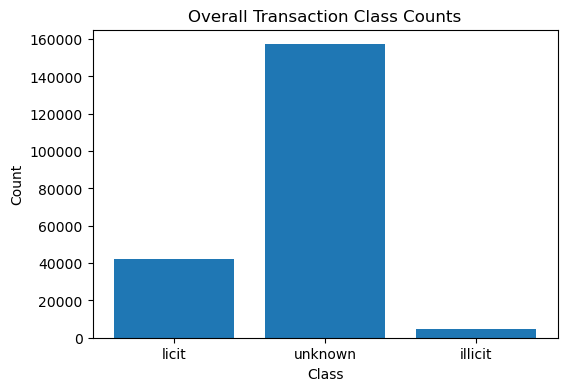

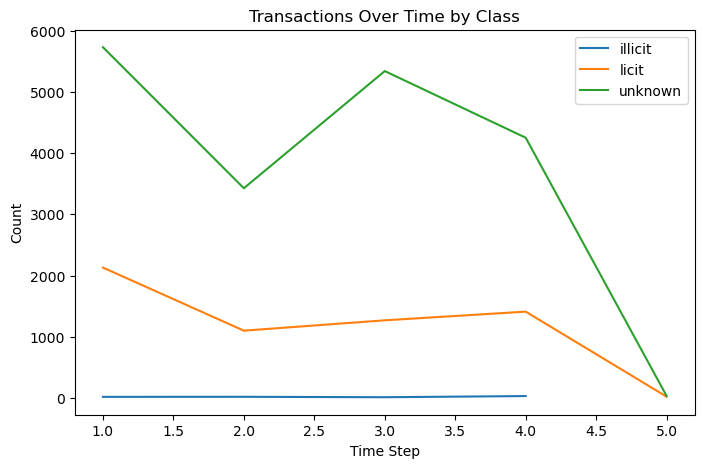

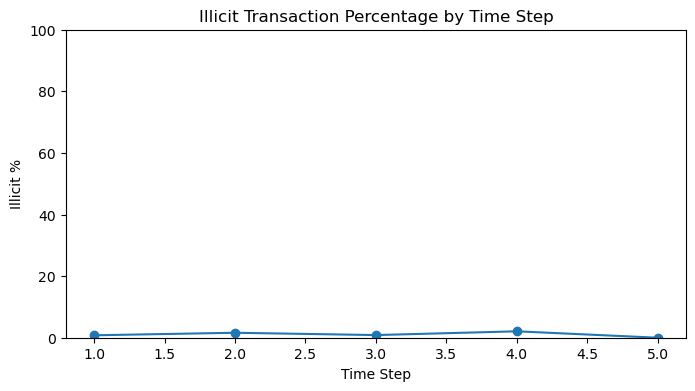

In [66]:
# Class & Time‑Step Trends
import matplotlib.pyplot as plt

# 1. Bar chart: overall class counts
class_counts = elliptic_txs_classes_df.groupBy("label").count().toPandas()
plt.figure(figsize=(6,4))
plt.bar(class_counts['label'], class_counts['count'])
plt.title("Overall Transaction Class Counts")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# 2. Line chart: transactions by time_step & label
time_class_dist_pd = time_class_dist.toPandas()
plt.figure(figsize=(8,5))
for lbl in time_class_dist_pd['label'].unique():
    subset = time_class_dist_pd[time_class_dist_pd['label']==lbl]
    plt.plot(subset['time_step'], subset['count'], label=lbl)
plt.title("Transactions Over Time by Class")
plt.xlabel("Time Step")
plt.ylabel("Count")
plt.legend()
plt.show()

# 3. Line chart: illicit % over time
illicit_pct_by_time_pd = illicit_pct_by_time.toPandas()
plt.figure(figsize=(8,4))
plt.plot(illicit_pct_by_time_pd['time_step'], illicit_pct_by_time_pd['illicit_percentage'], marker='o')
plt.title("Illicit Transaction Percentage by Time Step")
plt.xlabel("Time Step")
plt.ylabel("Illicit %")
plt.ylim(0,100)
plt.show()


StatementMeta(team14elliptic, 23, 36, Finished, Available, Finished)

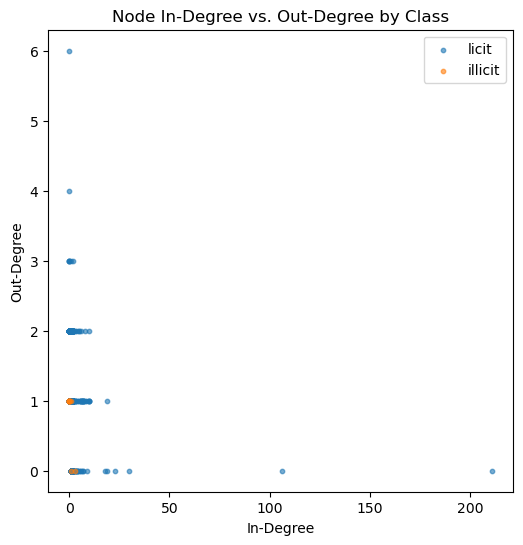

In [68]:
#Scatter of Degree Metrics by Class

import matplotlib.pyplot as plt

# Sample 10% of your supervised_data for plotting
scatter_pd = supervised_data.select("in_degree", "out_degree", "label") \
    .sample(False, 0.1, seed=42) \
    .toPandas()

plt.figure(figsize=(6,6))
for lbl in scatter_pd['label'].unique():
    sub = scatter_pd[scatter_pd['label'] == lbl]
    plt.scatter(sub['in_degree'], sub['out_degree'],
                s=10, label=lbl, alpha=0.6)

plt.title("Node In‑Degree vs. Out‑Degree by Class")
plt.xlabel("In‑Degree")
plt.ylabel("Out‑Degree")
plt.legend()
plt.show()


StatementMeta(team14elliptic, 23, 37, Finished, Available, Finished)

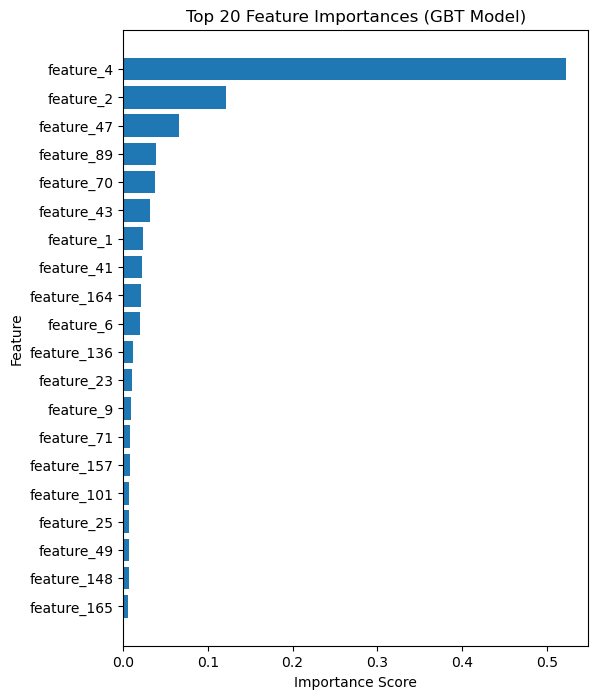

In [69]:
#Top‑20 Feature Importances 

import matplotlib.pyplot as plt

# Convert top-20 importances to Pandas
fi_pd = feature_importance_df.toPandas().sort_values('importance', ascending=True)

plt.figure(figsize=(6,8))
plt.barh(fi_pd['feature'], fi_pd['importance'])
plt.title("Top 20 Feature Importances (GBT Model)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


StatementMeta(team14elliptic, 23, 39, Finished, Available, Finished)

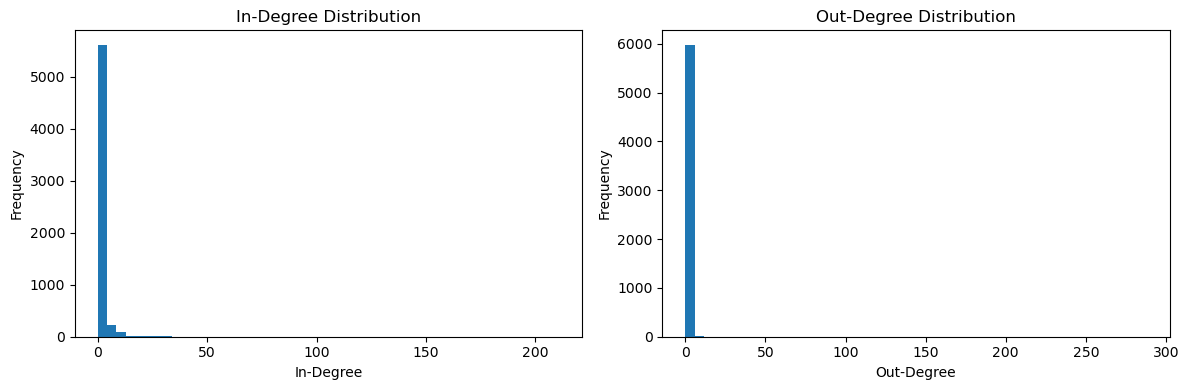

In [71]:
#Degree Distribution Histograms 

import matplotlib.pyplot as plt

# Pull to Pandas
deg_pd = supervised_data.select("in_degree", "out_degree").toPandas()

plt.figure(figsize=(12,4))

# In‑degree histogram
plt.subplot(1,2,1)
plt.hist(deg_pd['in_degree'], bins=50)
plt.title('In‑Degree Distribution')
plt.xlabel('In‑Degree')
plt.ylabel('Frequency')

# Out‑degree histogram
plt.subplot(1,2,2)
plt.hist(deg_pd['out_degree'], bins=50)
plt.title('Out‑Degree Distribution')
plt.xlabel('Out‑Degree')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


StatementMeta(team14elliptic, 23, 40, Finished, Available, Finished)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:117: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


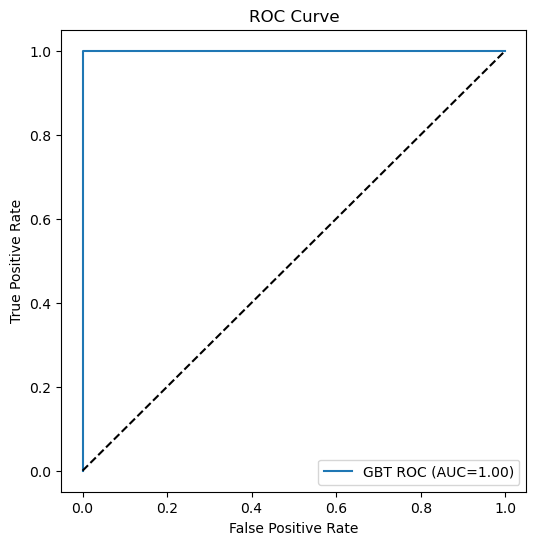

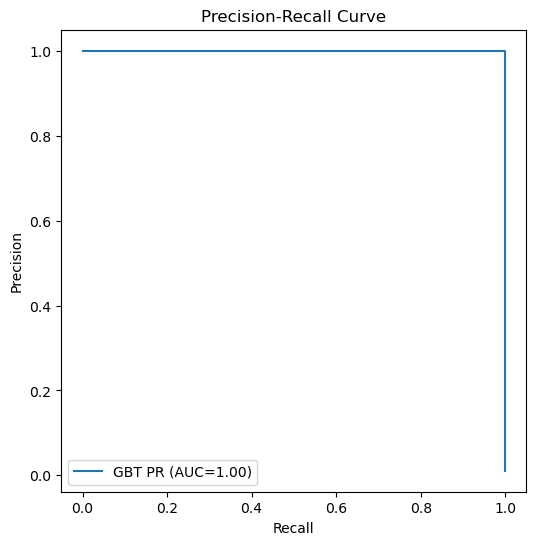

In [72]:
#ROC & Precision‑Recall Curves (GBT Model)

from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# Convert Spark preds to Pandas
preds_pd = gbt_predictions.select("probability", "label_numeric").toPandas()
preds_pd['score'] = preds_pd['probability'].apply(lambda v: float(v[1]))
y_true = preds_pd['label_numeric']
y_score = preds_pd['score']

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'GBT ROC (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Precision‑Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_score)
pr_auc = auc(recall, precision)
plt.figure(figsize=(6,6))
plt.plot(recall, precision, label=f'GBT PR (AUC={pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision‑Recall Curve')
plt.legend()
plt.show()


StatementMeta(team14elliptic, 23, 41, Finished, Available, Finished)

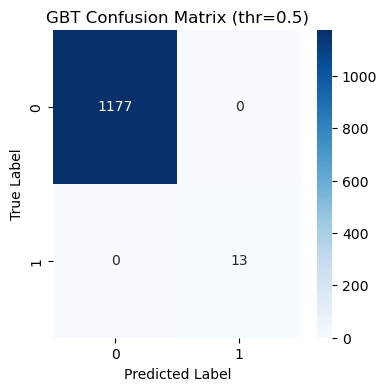

In [73]:
#Confusion Matrix Heatmap 

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix at threshold=0.5
y_pred = (y_score >= 0.5).astype(int)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('GBT Confusion Matrix (thr=0.5)')
plt.show()


StatementMeta(team14elliptic, 23, 43, Finished, Available, Finished)

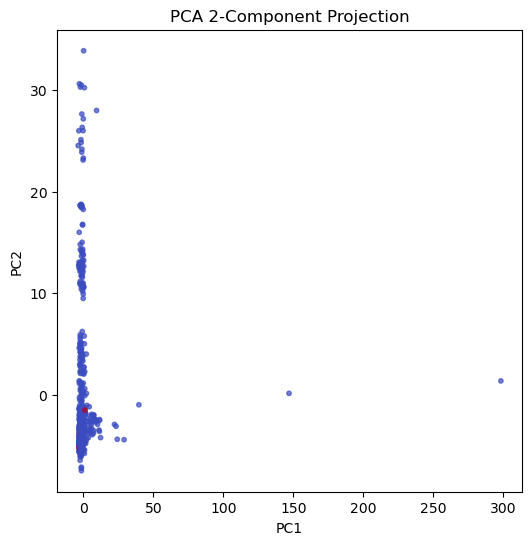

In [75]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Sample and to Pandas
pca_pd = supervised_data.select(*feature_cols, "label_numeric")\
            .sample(False, 0.1, seed=42).toPandas()

pca = PCA(n_components=2)
coords = pca.fit_transform(pca_pd[feature_cols])

plt.figure(figsize=(6,6))
plt.scatter(coords[:,0], coords[:,1], c=pca_pd['label_numeric'],
            cmap='coolwarm', s=10, alpha=0.7)
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('PCA 2‑Component Projection')
plt.show()


StatementMeta(team14elliptic, 23, 44, Finished, Available, Finished)

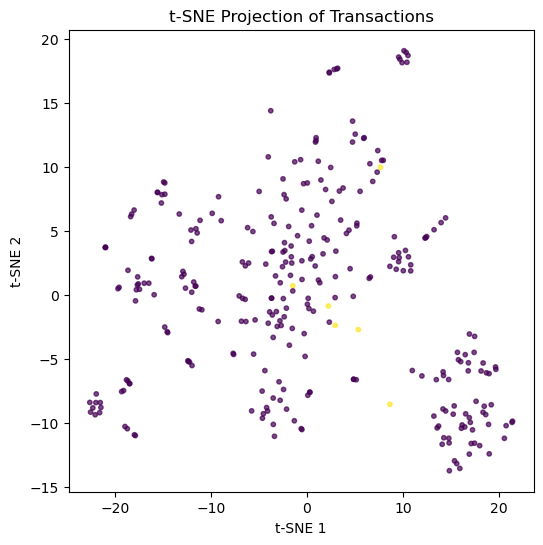

In [76]:
#Visualization Block 10: t‑SNE 2D Projection 

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Smaller sample for t‑SNE
tsne_pd = supervised_data.select(*feature_cols, "label_numeric")\
             .sample(False, 0.05, seed=42).toPandas()

tsne = TSNE(n_components=2, random_state=42)
emb = tsne.fit_transform(tsne_pd[feature_cols])

plt.figure(figsize=(6,6))
plt.scatter(emb[:,0], emb[:,1], c=tsne_pd['label_numeric'],
            cmap='viridis', s=10, alpha=0.7)
plt.xlabel('t‑SNE 1'); plt.ylabel('t‑SNE 2')
plt.title('t‑SNE Projection of Transactions')
plt.show()


In [59]:
# The error shows permissions issues with SQL operations and directory deletion

# 11. Simplified approach to save the cleaned and processed data to Gold container
# ------------------------------------------------------

# Simple function to save dataframes to Azure storage without SQL operations
def save_data_simple(df, name):
    try:
        # Use a simple write with a unique path to avoid conflicts
        import time
        timestamp = int(time.time())
        
        # Save as CSV with timestamp to avoid conflicts
        output_path = f"wasbs://team14-blobcontainer@{storage_account_name}.blob.core.windows.net/Gold/{name}_{timestamp}"
        
        df.write.format("csv") \
            .option("header", "true") \
            .mode("overwrite") \
            .save(output_path)
        
        print(f"Successfully saved {name} to {output_path}")
        return output_path
    except Exception as e:
        print(f"Error saving {name}: {str(e)}")
        return None

# Save the main datasets with the simplified approach
print("Saving processed datasets to Gold container...")

# Save only the most essential datasets to minimize errors
datasets = {
    "features_enhanced": features_enhanced,
    "supervised_data": supervised_data, 
    "model_predictions": gbt_predictions
}

saved_paths = {}
for name, df in datasets.items():
    path = save_data_simple(df, name)
    if path:
        saved_paths[name] = path

# Create summary files with key statistics
# These are smaller and more likely to save successfully

# 1. Class distribution summary
class_summary = supervised_data.groupBy("label").count()
save_data_simple(class_summary, "class_distribution")

# 2. Feature importance summary (top features only)
feature_importances = best_gbt_model.stages[-1].featureImportances.toArray()
feature_names = feature_cols

# Create a DataFrame with feature importance - just top 20 features
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
import pandas as pd

# Convert to pandas then back to Spark DataFrame
feature_imp_pd = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})
feature_imp_pd = feature_imp_pd.sort_values('importance', ascending=False).head(20)

feature_imp_schema = StructType([
    StructField("feature", StringType(), True),
    StructField("importance", DoubleType(), True)
])

feature_importance_df = spark.createDataFrame(feature_imp_pd, schema=feature_imp_schema)
save_data_simple(feature_importance_df, "top_feature_importance")

# 3. Model performance metrics summary
from pyspark.sql.types import StructType, StructField, StringType, DoubleType

# Create a small DataFrame with just the performance metrics
metrics_data = [
    ("Isolation Forest", float(isolation_auc), None, None, None),
    ("XGBoost", float(gbt_auc), float(precision), float(recall), float(f1))
]
metrics_schema = StructType([
    StructField("model", StringType(), True),
    StructField("auc", DoubleType(), True),
    StructField("precision", DoubleType(), True),
    StructField("recall", DoubleType(), True),
    StructField("f1", DoubleType(), True)
])
metrics_df = spark.createDataFrame(metrics_data, schema=metrics_schema)
save_data_simple(metrics_df, "model_metrics")

StatementMeta(team14elliptic, 23, 27, Finished, Available, Finished)

Saving processed datasets to Gold container...
Error saving features_enhanced: An error occurred while calling o42221.save.
: org.apache.hadoop.fs.azure.AzureException: com.microsoft.azure.storage.StorageException: This operation is not permitted on a non-empty directory.
	at org.apache.hadoop.fs.azure.AzureNativeFileSystemStore.delete(AzureNativeFileSystemStore.java:2720)
	at org.apache.hadoop.fs.azure.AzureNativeFileSystemStore.delete(AzureNativeFileSystemStore.java:2730)
	at org.apache.hadoop.fs.azure.NativeAzureFileSystem.deleteFile(NativeAzureFileSystem.java:2670)
	at org.apache.hadoop.fs.azure.NativeAzureFileSystem$2.execute(NativeAzureFileSystem.java:2421)
	at org.apache.hadoop.fs.azure.AzureFileSystemThreadPoolExecutor.executeParallel(AzureFileSystemThreadPoolExecutor.java:223)
	at org.apache.hadoop.fs.azure.NativeAzureFileSystem.deleteWithoutAuth(NativeAzureFileSystem.java:2433)
	at org.apache.hadoop.fs.azure.NativeAzureFileSystem.delete(NativeAzureFileSystem.java:2483)
	at or